In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

%run utils.py
import utils
from importlib import reload
reload(utils);

# Context

We have some data (actual or fake) and we want to synthesise another variable in such a way that it: a) obeys some bounds of validity, and; b) makes sense with relation to the other data.


Actual use-cases of generating generating synthetic tables that obey bounds and relation to other data could be:
1. unit / system testing
2. sanitising data to allow external contractors to develop algorithms
3. sanitising data for demonstrations (LOPs, conferences, etc.)

## Specific example here
Here we're looking at subgroup comparisons of an A/B experiment: where one has many many records of a `delta` (this is the measured effect) and `nobs` (the sample size for that particular subgroup) and wants to generate p-values that are valid (between 0 and 1) and bear some relation to the size of the effect (`|delta|`) and the sample size.

### First, let's just generate some 'experiments' directly from a uniform

In [2]:
n = 1000
df = pd.DataFrame({
    'delta': stats.uniform(-0.06, 0.12).rvs(n),
    'nobs':  stats.uniform(1, 1e6).rvs(n).astype(int)
})
df.sample(5)  

,delta,nobs
99,0.046959,304673
958,-0.032008,484314
200,-0.015895,73498
461,-0.056290,362453
262,-0.036919,483324


### Now, define how we want the p-values to look

We know bounds are 0 to 1. Further, we want the p-values to generally make sense with the effect and sample size, that is:
a) increasing magnitude of delta should lead generally to smaller p-values
b) increasing sample size should lead generally to smaller p-values

#### uniform distribution
This could be generated by a uniform distribution, but the mean and variance are fixed given set bounds. Also, a uniform distribution is not realistic for p-values: they will likely be skewed in some way.

#### truncated normal
Another possibility is the use of a 'truncated' normal: which is simply a gaussian that is clipped at the bounds. These sort of distributions are problematic because:
a) they're not normally distributed as they'll have an increase on mass exactly on the bounds (you'll get a lot more 0s and 1s than you should do here)
b) they're hard to tune to get the desired mean and variance: it's essentially an optimisation problem to get the parameterisation that would yield the right mean and variance after truncation

NB: other distributions (e.g. gamma) can be 'truncated' but they'll all have the same issues as the truncated normal. 

#### beta distribution
The [beta-distribution](https://en.wikipedia.org/wiki/Beta_distribution) is ideal for this: it is bounded, and is parameterised in such a way (with the two parameters $\alpha$ and $\beta$) that most meaningful mean and variances between the bounds can be achieved.

The relation between mean and variance and the 2 parameters is not fully defined (multiple parameter settings can yield a certain mean and variance), but the following function uses a convenient simplification that gives us nice concave distributions throughout the range of means (I havent gone into this derivation, but the function works well).

In [3]:
def getAlphaBeta(mu, sigma):
    """
    Estimate parameters of beta dist.
    from: https://stats.stackexchange.com/a/395329
    """
    alpha = mu**2 * ((1 - mu) / sigma**2 - 1 / mu)
    beta = alpha * (1 / mu - 1)
    return (alpha, beta)

### check the distribution
Let's test the function quickly to ensure the resulting distribution is as we expect... We're going to look at the density function (PDF) for multiple desired mean values ($\mu$).
We'll visualise it, and for each mean value, we check that the distribution's mean and standard deviation are not too different from the requested values...

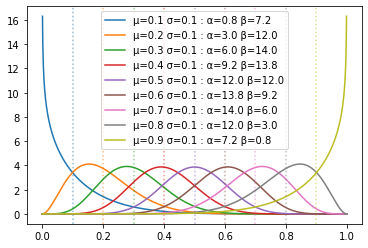

In [4]:
x = pd.np.arange(0, 1, 0.001)

σ = 0.1
for (μ) in pd.np.arange(0.1, 0.99, 0.1):
    (α, β) = getAlphaBeta(μ, σ)
    rvar = stats.beta(a=α,b=β)
    assert abs(rvar.mean() - μ) < 0.05
    assert abs(rvar.std() - σ) < 0.05
    y = rvar.pdf(x)
    ax = plt.plot(x, y, label=f'μ={μ:.1f} σ={σ:.1f} : α={α:.1f} β={β:.1f}')
    plt.axvline(rvar.mean(), color=ax[0]._color, linestyle=':', alpha=0.5)

plt.legend();

We can also generate some dummy samples and check the empirical histograms make sense...

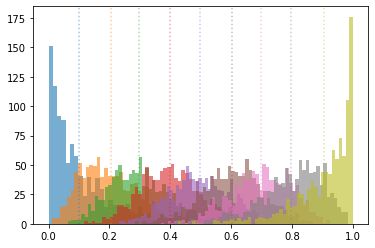

In [5]:
for (μ) in pd.np.arange(0.1, 0.99, 0.1):
    sample = stats.beta(*getAlphaBeta(μ, σ)).rvs(1000)
    ax = plt.hist(sample, bins=50, alpha=0.6);
    plt.axvline(sample.mean(), color=ax[2][0]._facecolor, linestyle=':', alpha=0.4)

### With the distribution set, we can define how we want the p-values to correspond to the existing data

That is, we define how the p-values should change with sample size and effect...

This step is usually referred to by modellers (statisticians, data scientists, etc.) as defining the generative model. This could be done in a programmatic language like Stan or PyMC3. This would also have the very nice advantage of being able to easily visualise the 'model': that is, what the contributing factors are to how you generate your new data.

However, here the point is to show how to do this without learning a new language or package, but using the basic scipy and pandas functionality that most are already familiar with.

The 'generative model' is defined here by the `p_val_mean` function. It basically just:
1. rescales the delta to have meaningful range relative to sample size
2. multiplies the delta and sample size together (as they both should contribute)
3. scales this result
4. inverts the logarithm of this to implement the desired inverse relationship such that the p-value can never actually be 0 

Note: this function could take on many many forms: feel free to play with other forms (e.g. without the logarithm).

Note: the output here is just the *mean* of what we want the p-value to look like: this will be the input to the random number generator to get stochastic p-values.

In the following figures you can see how the p-value mean:
- decreases as the delta magnitude increase (multiple lines)
- decreases as the sample size increases, tending toward 0

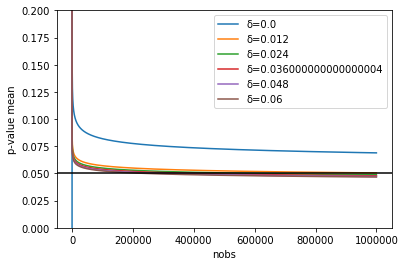

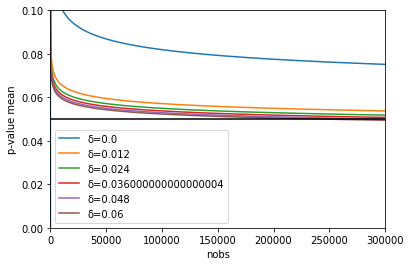

In [6]:
max_delta_abs = 0.06 # should lead to lowest p-value mean
min_delta_abs = 0 # should lead to highest p-value mean
max_delta_effect = 0.5 # max amount that delta modulates nobs_effect

def p_val_mean(delta, nobs):
    nobs_effect = 1/pd.np.log(utils.rescale(pd.np.abs(delta), (1, 1e3), (0, max_delta_abs))*2*(nobs))
    return nobs_effect 

nobs_test = pd.np.arange(0.01, 1e6, 1e2)

for δ in pd.np.arange(0.000, max_delta_abs + 0.00001, max_delta_abs/5.):
    plt.plot(nobs_test, p_val_mean(δ, nobs_test), label=f'δ={δ}')
plt.xlabel('nobs');
plt.ylabel('p-value mean')
plt.legend();
plt.axhline(0.05, color='k')
plt.ylim(0, 0.2);

# now zoomed in a little:
plt.figure()
for δ in pd.np.arange(0.000, max_delta_abs + 0.00001, max_delta_abs/5.):
    plt.plot(nobs_test, p_val_mean(δ, nobs_test), label=f'δ={δ}')
plt.xlabel('nobs');
plt.ylabel('p-value mean')
plt.legend();
plt.axhline(0.05, color='k')
plt.ylim(0, 0.1);
plt.xlim(0, 300000);

For ease, let's apply this model to the data and store the resulting 'p value means' as a column

In [7]:
df['p_val_mean'] = p_val_mean(df['delta'], df['nobs'])

### Now all that's left to do is to actually generate samples

We generate samples from the random-number generator fed with the result of the mean function).

We're doing this with an `apply` because each row potentially has a different set of parameters for the random variable (i.e. different delta and nobs).

Variance (by way of standard deviation) is just being set arbitrarily. We could have made this also vary based on data. Fiddle to your heart's content...

NB: the exception handling is necessary because not all mean/variances are possible in the beta distribution: the variance is constrained by the mean mathematically. If we violate that, we just return a nan. More intelligent approach is possible e.g. by encoding the constraint on the variance explicitly...

In [8]:
stddev = 0.005
def generate_single_p_val(row):
    try:
        return stats.beta(*getAlphaBeta(row['p_val_mean'], stddev)).rvs()
    except ValueError:
        return pd.np.nan
    
df['p_val'] = df.apply(generate_single_p_val, axis=1)

### That's it!

Now we see that the p-values are stochastic, but:
- they're relating clearly to the delta and sample size
- they're always valid...

,delta,nobs,p_val_mean,p_val
148,0.048173,540381,0.048587,0.059237
844,0.058144,301315,0.049541,0.047165
925,-0.037503,566926,0.049069,0.046439
461,-0.056290,362453,0.049170,0.053192
348,-0.026137,235639,0.052243,0.056854


,p_val
count,1000.000000
mean,0.052084
std,0.006318
min,0.034102
25%,0.047646
50%,0.051705
75%,0.056156
max,0.074191


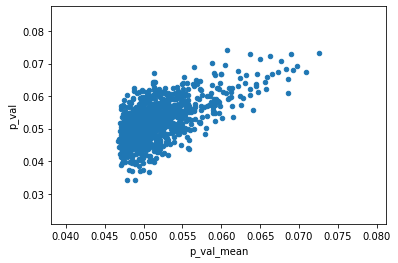

In [9]:
display(df[['delta', 'nobs', 'p_val_mean', 'p_val']].sample(5))
display(pd.DataFrame(df['p_val'].describe()))

df.plot(x='p_val_mean', y='p_val', kind='scatter');